In [53]:
import warnings
warnings.filterwarnings("ignore")
#for handling RAM
import gc 

#stats
from statsmodels.stats.anova import AnovaRM
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
import pingouin as pg
from matplotlib.colors import LinearSegmentedColormap


#my to go packages
import math
import random
import pandas as pd
import numpy as np

#plotting
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.gridspec import GridSpec
from matplotlib import cm
import matplotlib.ticker as ticker


#for readin
import glob # Package for Unix-style pathname pattern expansion
import os   # Python operating system interface

#for signal processing
from scipy.interpolate import CubicSpline,interp1d
import scipy.signal as signal
import scipy.stats as stats
from scipy.signal import filtfilt, butter
from scipy.fft import rfft, rfftfreq
from scipy.stats import sem 
from scipy.stats import norm
from scipy.stats import ttest_rel
from scipy.optimize import curve_fit,minimize

#other packages
import ast
import itertools
from itertools import groupby
from more_itertools import consecutive_groups
import more_itertools as mit
from operator import itemgetter
import statistics
from sklearn.mixture import GaussianMixture

#nilearn
from nilearn import plotting, image
from nilearn.image import mean_img
from nilearn.plotting import plot_anat, plot_img, plot_stat_map, show, plot_design_matrix
from nilearn.glm import threshold_stats_img
from nilearn.glm.first_level import FirstLevelModel, make_first_level_design_matrix
from nilearn.reporting import get_clusters_table

In [31]:
filepath = '/Volumes/kiyonaga/MIPS/fMRI/subjects/MIPS_103/anat'
c = glob.glob(filepath+ '/c5**.nii')
c
#subj103_anat = image.load_img(c)
#subj103_anat
#plotting.plot_stat_map(subj103_anat)

['/Volumes/kiyonaga/MIPS/fMRI/subjects/MIPS_103/anat/c5s2018-08-05_10-17-102019-00001-00160-1.nii',
 '/Volumes/kiyonaga/MIPS/fMRI/subjects/MIPS_103/anat/c5cs2018-08-05_10-17-102019-00001-00160-1.nii']

#### default background

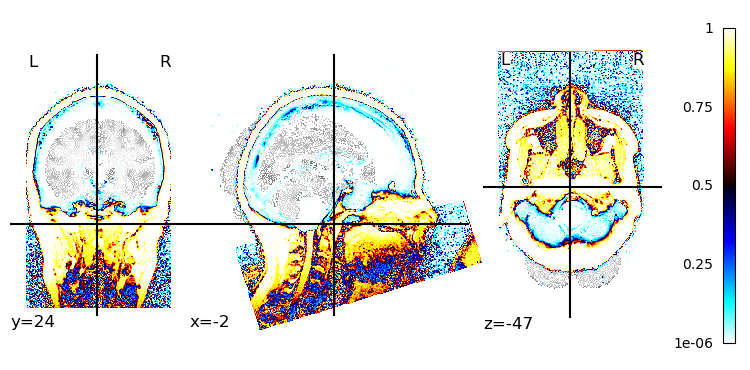

In [84]:
anat = image.load_img('/Volumes/kiyonaga/MIPS/fMRI/subjects/MIPS_103/anat/c5s2018-08-05_10-17-102019-00001-00160-1.nii')
plotting.plot_stat_map(anat)

##### given anat

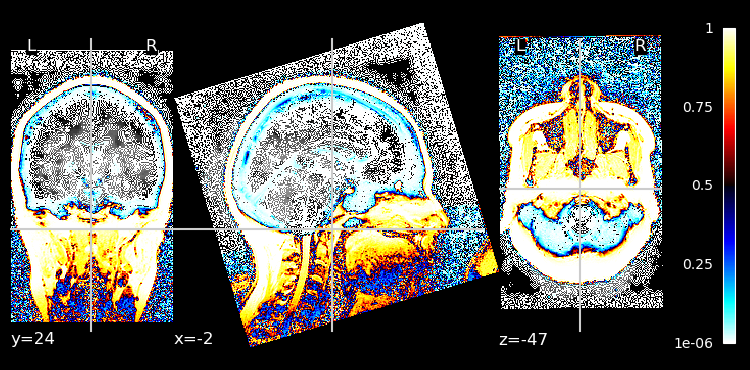

In [83]:
anat = image.load_img('/Volumes/kiyonaga/MIPS/fMRI/subjects/MIPS_103/anat/c5s2018-08-05_10-17-102019-00001-00160-1.nii')
plotting.plot_stat_map(anat, bg_img='anat/wc0cs2018-08-05_10-17-102019-00001-00160-1.nii')


## tried with new data (wrraf rather than the srraf files), should be normalized

In [56]:
import warnings
from nilearn.image import concat_imgs, mean_img, resample_img

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    four_runs = [
        concat_imgs(os.path.join('/Volumes/kiyonaga/MIPS/fMRI/subjects/MIPS_103/func', f'run0{run}', 'wrraf*.nii'), auto_resample=True) for run in np.arange(4) + 1
    ]
affine, shape = four_runs[0].affine, four_runs[0].shape

four_runs[1] = resample_img(
    four_runs[1], affine, shape[:3],force_resample=True
)

tr = 2.0 
hrf_model = "spm + derivative"

design_matrices = []
for run in np.arange(4) + 1:

    pattern = os.path.join('/Volumes/kiyonaga/MIPS/fMRI/subjects/MIPS_103/func', f'run0{run}', 'wrraf*.nii')
    nii_files = glob.glob(pattern)
    n_scans = image.load_img(nii_files).shape[-1] #number of scans per acquisition
    frame_times = np.arange(n_scans) * tr  # here are the corresponding frame times
    tsv_file = pd.read_csv(f'func/run0{run}/events.tsv', sep='\t')
    events = tsv_file[['onset', 'duration']]
    design_mat = make_first_level_design_matrix(
        frame_times,
        events,
        hrf_model=hrf_model,
    )
    design_matrices.append(design_mat)

In [57]:
first_level_model = FirstLevelModel(
    t_r=2,
    noise_model="ar1",
    standardize=False,
    hrf_model="spm",
    drift_model="cosine",
)

fitted_models = []
for i, (run_img, design_matrix) in enumerate(zip(four_runs, design_matrices)):
    print(f"Fitting model for run {i + 1}")
    model = first_level_model.fit(run_img, design_matrices=design_matrix)
    fitted_models.append(model)


contrast_matrix = np.eye(design_matrices[0].shape[1]) 
task_contrast = contrast_matrix[0] 

z_maps = []
for i, model in enumerate(fitted_models):
    print(f"Computing contrast for run {i + 1}")
    z_map = model.compute_contrast(task_contrast, output_type='z_score')
    z_maps.append(z_map)

Fitting model for run 1
Fitting model for run 2
Fitting model for run 3
Fitting model for run 4
Computing contrast for run 1
Computing contrast for run 2
Computing contrast for run 3
Computing contrast for run 4


Plotting Z map for run 1


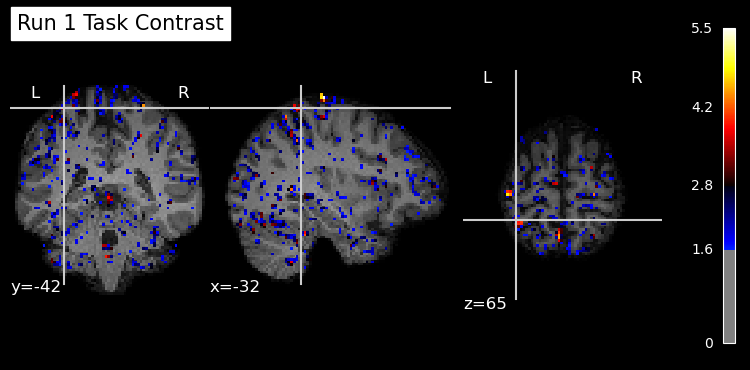

Plotting Z map for run 2


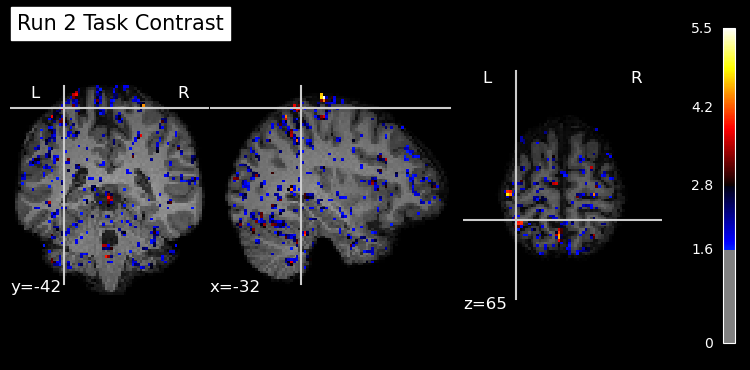

Plotting Z map for run 3


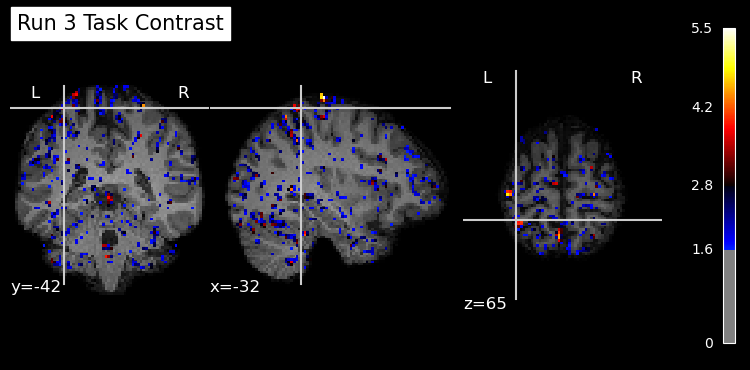

Plotting Z map for run 4


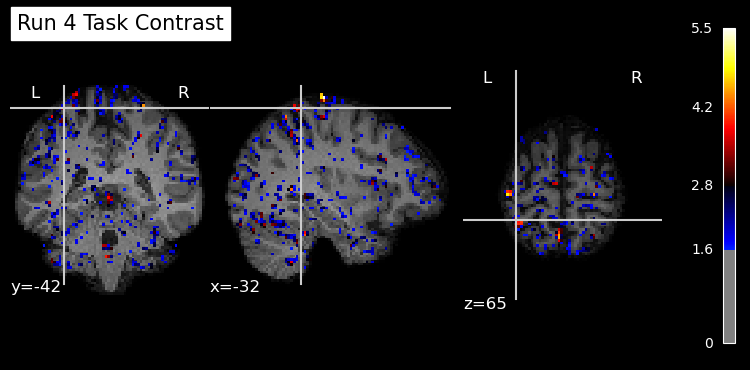

In [62]:
# Visualize each z-map for the contrast
for i, z_map in enumerate(z_maps):
    clean_map, threshold = threshold_stats_img(
    z_map,
    alpha=0.05,
    height_control="fpr", # false positive rate
    two_sided=False,  # using a one-sided test
    )
    print(f"Plotting Z map for run {i + 1}")
    display = plot_stat_map(
        clean_map, 
        title=f"Run {i + 1} Task Contrast", 
        threshold=threshold, 
        display_mode='ortho', 
        bg_img='anat/wc0cs2018-08-05_10-17-102019-00001-00160-1.nii')
    plt.show()

In [63]:
from nilearn.reporting import get_clusters_table

table = get_clusters_table(
    z_map, stat_threshold=threshold, cluster_threshold=20
)
table

,Cluster ID,X,Y,Z,Peak Stat,Cluster Size (mm3)
0,1,-32.0,-26.0,74.0,5.541469,11176
1,1a,-38.0,-24.0,68.0,5.066560,
2,1b,-28.0,-30.0,78.0,5.028141,
3,1c,-12.0,-76.0,58.0,4.638972,
4,2,6.0,-66.0,-4.0,5.336591,2856
...,...,...,...,...,...,...
282,119a,-54.0,-38.0,10.0,2.244849,
283,120,-30.0,38.0,30.0,2.419021,480
284,120a,-36.0,40.0,36.0,2.378908,
285,120b,-28.0,34.0,30.0,2.344788,


### a stricter threshold

Plotting Z map for run 1


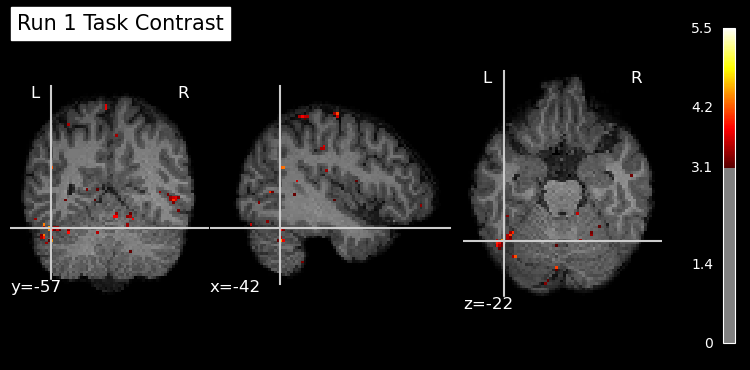

Plotting Z map for run 2


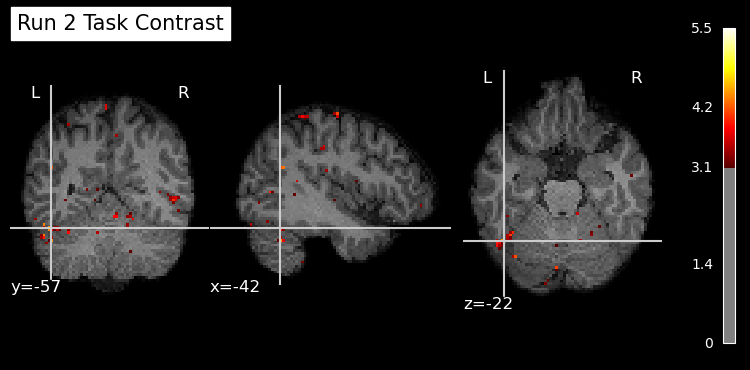

Plotting Z map for run 3


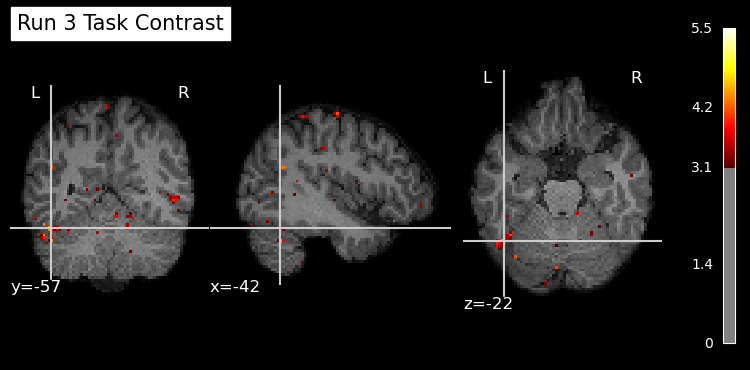

Plotting Z map for run 4


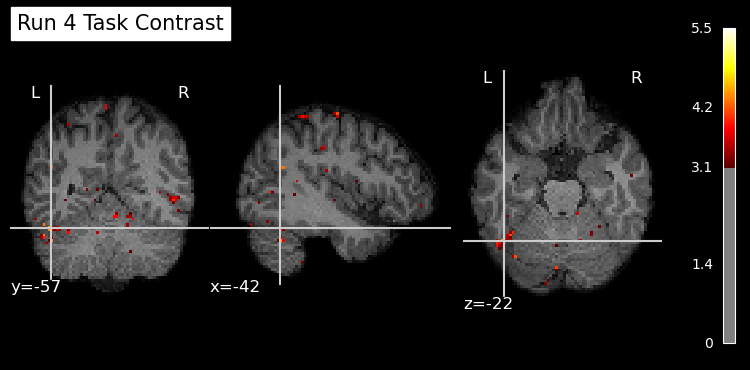

In [78]:
# Visualize each z-map for the contrast
for i, z_map in enumerate(z_maps):
    clean_map, threshold = threshold_stats_img(
    z_map,
    alpha=0.001,
    height_control="fpr", # false positive rate
    two_sided=False,  # using a one-sided test
    )
    print(f"Plotting Z map for run {i + 1}")
    display = plot_stat_map(
        clean_map, 
        title=f"Run {i + 1} Task Contrast", 
        threshold=threshold, 
        display_mode='ortho', 
        bg_img='anat/wc0cs2018-08-05_10-17-102019-00001-00160-1.nii')
    plt.show()

In [79]:
from nilearn.reporting import get_clusters_table

table = get_clusters_table(
    z_map, stat_threshold=threshold, cluster_threshold=20
)
table

,Cluster ID,X,Y,Z,Peak Stat,Cluster Size (mm3)
0,1,-32.0,-26.0,74.0,5.541469,216
1,1a,-24.0,-28.0,80.0,4.962554,
2,2,6.0,-66.0,-4.0,5.336591,216
3,3,52.0,-60.0,0.0,4.676687,248
4,4,-12.0,-76.0,58.0,4.638972,176
5,5,-44.0,-58.0,-22.0,4.408460,264
6,5a,-36.0,-52.0,-24.0,4.285083,
7,5b,-38.0,-60.0,-24.0,3.582321,
8,6,-28.0,-44.0,70.0,4.185086,216
9,6a,-36.0,-46.0,62.0,4.119619,


Plotting Z map for run 1


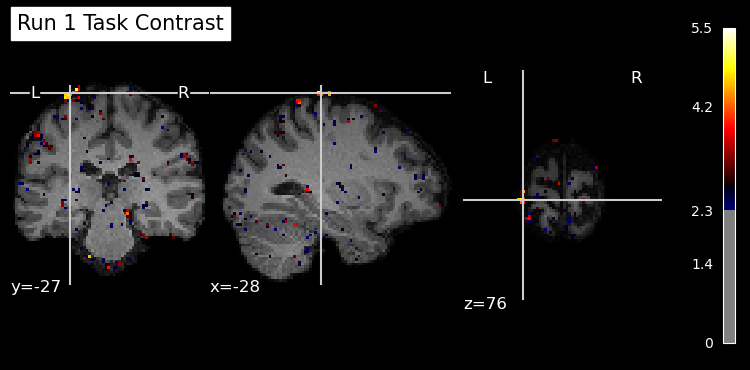

Plotting Z map for run 2


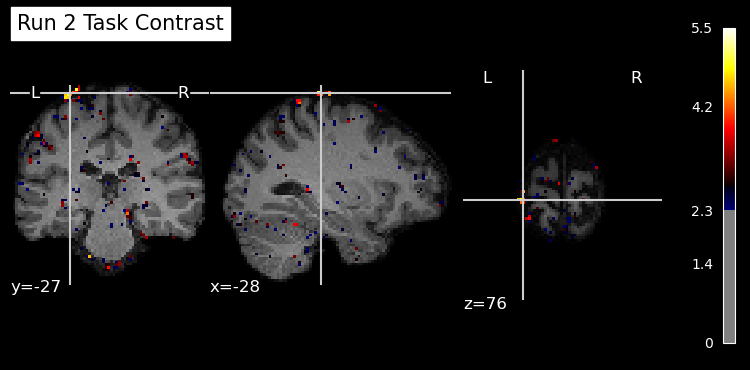

Plotting Z map for run 3


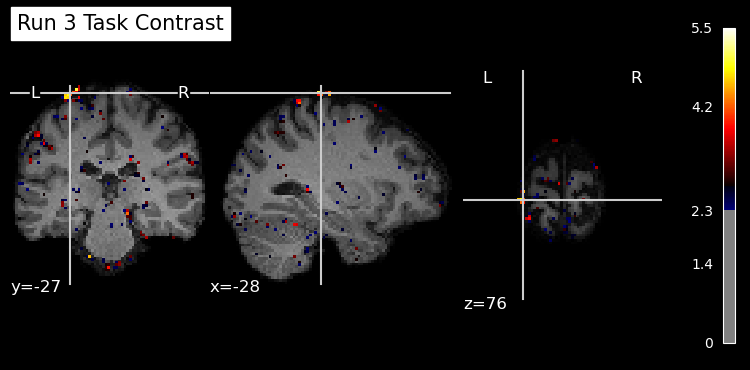

Plotting Z map for run 4


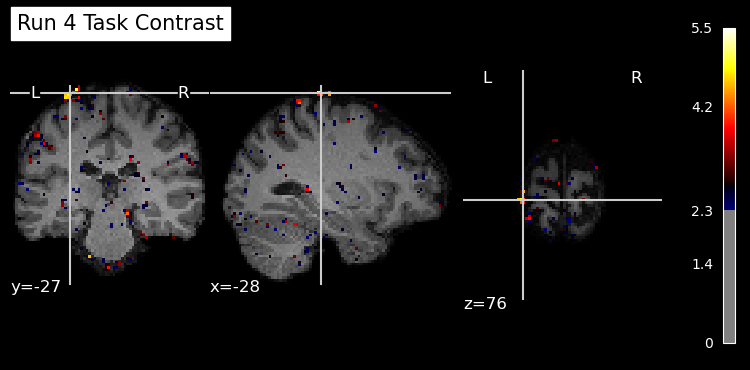

In [80]:
# Visualize each z-map for the contrast
for i, z_map in enumerate(z_maps):
    clean_map, threshold = threshold_stats_img(
    z_map,
    alpha=0.01,
    height_control="fpr", # false positive rate
    two_sided=False,  # using a one-sided test
    )
    print(f"Plotting Z map for run {i + 1}")
    display = plot_stat_map(
        clean_map, 
        title=f"Run {i + 1} Task Contrast", 
        threshold=threshold, 
        display_mode='ortho', 
        bg_img='anat/wc0cs2018-08-05_10-17-102019-00001-00160-1.nii')
    plt.show()

In [81]:
from nilearn.reporting import get_clusters_table

table = get_clusters_table(
    z_map, stat_threshold=threshold, cluster_threshold=20
)
table

,Cluster ID,X,Y,Z,Peak Stat,Cluster Size (mm3)
0,1,-32.0,-26.0,74.0,5.541469,2144
1,1a,-38.0,-24.0,68.0,5.066560,
2,1b,-28.0,-30.0,78.0,5.028141,
3,1c,-28.0,-22.0,76.0,4.475016,
4,2,6.0,-66.0,-4.0,5.336591,368
5,2a,16.0,-66.0,-12.0,2.864694,
6,3,-46.0,-70.0,-2.0,5.084742,392
7,3a,-50.0,-68.0,-12.0,3.825917,
8,4,52.0,-60.0,0.0,4.676687,864
9,4a,50.0,-60.0,-14.0,3.758444,
